In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!unzip "/content/drive/MyDrive/HandWriten_Hack/CropImg.zip"

Archive:  /content/drive/MyDrive/HandWriten_Hack/CropImg.zip
replace 68Persons/is02002_4231456.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 68Persons/is02002_4231456.png  
  inflating: 68Persons/is02002_7895130.png  
  inflating: 68Persons/is02002_8103200.png  
  inflating: 68Persons/is02002_8135672.png  
  inflating: 68Persons/is02002_8742166.png  
  inflating: 68Persons/is02003_24.png  
  inflating: 68Persons/is02003_51.png  
  inflating: 68Persons/is02003_52.png  
  inflating: 68Persons/is02003_57.png  
  inflating: 68Persons/is02003_58.png  
  inflating: 68Persons/is02003_87.png  
  inflating: 68Persons/is02003_125.png  
  inflating: 68Persons/is02003_133.png  
  inflating: 68Persons/is02003_472.png  
  inflating: 68Persons/is02003_513.png  
  inflating: 68Persons/is02003_780.png  
  inflating: 68Persons/is02003_872.png  
  inflating: 68Persons/is02003_2012.png  
  inflating: 68Persons/is02003_4233.png  
  inflating: 68Persons/is02003_4253.png  
  inflating: 68Persons/

In [ ]:
# Path to the data directory
data_dir = Path("./68Persons/")
# Get list of all the images
images = list(map(str, list(data_dir.glob("*.png"))))

labels=[]
for img in images:
    a=img.split(os.path.sep)[-1].split(".png")[0].split('_')[-1]
    labels.append(a+" "*(8-len(a)))

characters = set(char for label in labels for char in label)
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  2491
Number of labels found:  2491
Number of unique characters:  11
Characters present:  {'6', '5', '9', ' ', '2', '1', '7', '4', '0', '8', '3'}


In [ ]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

#    gray_image = tf.squeeze(img) # shape (127,127,1) -> shape (127,127)
    #img = tf.where(img>220, tf.zeros_like(img),255*tf.ones_like(img) )

  #  img = tf.expand_dims(img, axis=-1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])

    img = tf.image.central_crop(img, 0.9)
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


In [ ]:
#img=tf.io.read_file('68Persons/is10007_926670.png')
#img = tf.io.decode_png(img, channels=1)
#img = tf.where(img>220, tf.zeros_like(img),255*tf.ones_like(img) )
#img = tf.image.convert_image_dtype(img, tf.float32)
#img = tf.image.resize(img, [img_height, img_width])
#img = tf.transpose(img, perm=[1, 0, 2])
#img = tf.image.central_crop(img, 0.9)

In [ ]:
#img1 = (img[ :, :, 0] * 255).numpy().astype(np.uint8)
#img1 = img1.T

In [ ]:
#plt.imshow(img1, cmap="gray")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(180, 46, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)


    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((180 // 4), (46 // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 180, 46, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 180, 46, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 90, 23, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 90, 23, 64)   18496       ['pool1[0][0]']       

In [ ]:
epochs = 70 #100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/70
141/141 [==============================] - 12s 47ms/step - loss: 16.3081 - val_loss: 14.3228
Epoch 2/70
141/141 [==============================] - 5s 36ms/step - loss: 13.8322 - val_loss: 14.4741
Epoch 3/70
141/141 [==============================] - 5s 37ms/step - loss: 13.2367 - val_loss: 12.9001
Epoch 4/70
141/141 [==============================] - 5s 36ms/step - loss: 12.8805 - val_loss: 12.8942
Epoch 5/70
141/141 [==============================] - 5s 36ms/step - loss: 12.7011 - val_loss: 12.5512
Epoch 6/70
141/141 [==============================] - 5s 37ms/step - loss: 12.5910 - val_loss: 12.4242
Epoch 7/70
141/141 [==============================] - 5s 37ms/step - loss: 12.5233 - val_loss: 12.5960
Epoch 8/70
141/141 [==============================] - 5s 36ms/step - loss: 12.5177 - val_loss: 12.5265
Epoch 9/70
141/141 [==============================] - 5s 36ms/step - loss: 12.4003 - val_loss: 12.2951
Epoch 10/70
141/141 [==============================] - 5s 37ms/step - lo

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 180, 46, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 180, 46, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 90, 23, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 90, 23, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 45, 11, 64)        0         
                                                                 
 reshape (Reshape)           (None, 45, 704)           0         
                                                                 
 dense1 (Dense)              (None, 45, 64)            4512

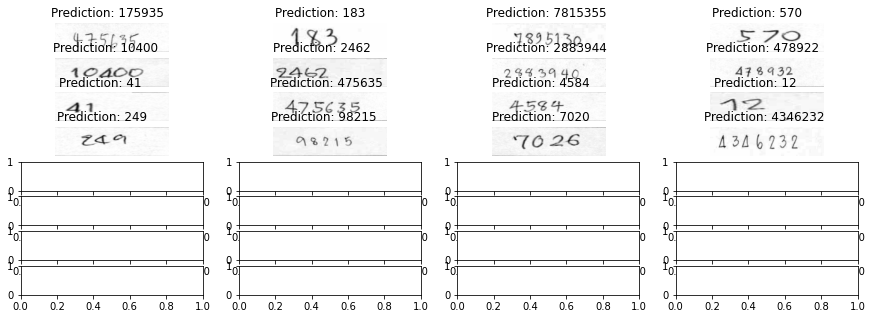

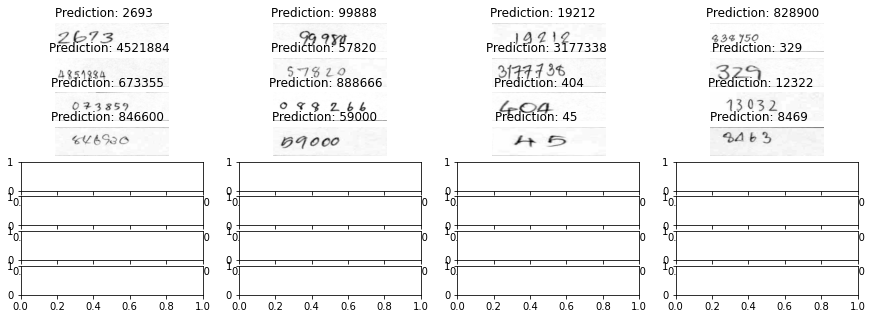

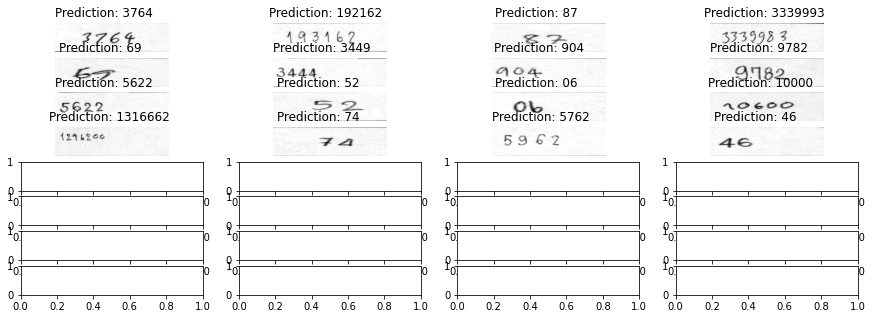

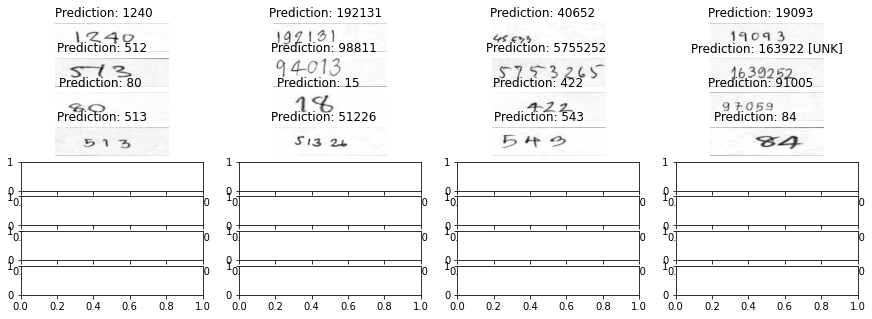

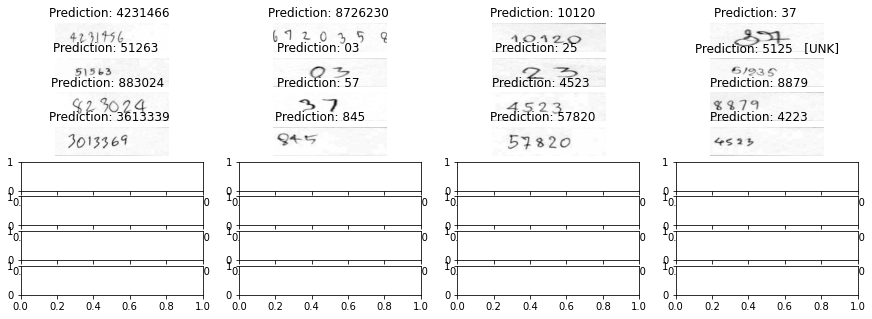

In [ ]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()



# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(5):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(8, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
    plt.show()

In [ ]:
!unzip "/content/drive/MyDrive/HandWriten_Hack/Testset_bb.zip"

Archive:  /content/drive/MyDrive/HandWriten_Hack/Testset_bb.zip
replace TestSet2/004c1ebd789f053fa997bbb7251da1f9.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: TestSet2/004c1ebd789f053fa997bbb7251da1f9.png  
  inflating: TestSet2/004d54be0db9e3fc021c95724b7c2b0d.png  
  inflating: TestSet2/007925a67659870be7b2f2c461df8368.jpg  
  inflating: TestSet2/007e62ad36ae31f8cd7c5ded1a70a0e4.png  
  inflating: TestSet2/008190b4cf2391510796fda7a27d7687.jpg  
  inflating: TestSet2/0086e76a421857d34cc1ae4b941c564e.jpeg  
  inflating: TestSet2/00874491ad4ab79ba5bc5b7a4df1e59e.jpg  
  inflating: TestSet2/008daab67f96b475aa6a3d31c5478f7e.png  
  inflating: TestSet2/00b5becf236fe77f06602fe9e856e8a9.png  
  inflating: TestSet2/00f315a4b714ac515add273a408adc05.png  
  inflating: TestSet2/0121ccaad3507e92b8ea4e67f93ddd76.png  
  inflating: TestSet2/012f591f17f4226bdb3caa90f6cb3474.jpeg  
  inflating: TestSet2/014aa1ddec3678fb1adf2449121b11af.jpg  
  inflating: TestSet2/01ce75ec4a4893a074c1cd17

In [ ]:
from PIL import Image
path = './TestSet2/'

files = os.listdir(path)
i=0
for f in files:
  name = f.split(os.path.sep)[-1].split('.')[0]
  im1 = Image.open(path+f)
  im1.save('/content/drive/MyDrive/HandWriten_Hack/testy/'+name+'.png')
  i=i+1

In [ ]:
data_dir2 = Path("./drive/MyDrive/HandWriten_Hack/testy/")
images_pre = list(map(str, list(data_dir2.glob("*.png"))))

In [ ]:
len(images_pre)

1300

In [ ]:
def encode_single_sample_pred(img_path):
# 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

#    gray_image = tf.squeeze(img) # shape (127,127,1) -> shape (127,127)
    #img = tf.where(img>220, tf.zeros_like(img),255*tf.ones_like(img) )

  #  img = tf.expand_dims(img, axis=-1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])

    img = tf.image.central_crop(img, 0.9)
    # 6. Map the characters in label to numbers

    return {"image": img}

In [ ]:
pred_dataset = tf.data.Dataset.from_tensor_slices(images_pre)
pred_dataset = (
    pred_dataset.map(
        encode_single_sample_pred, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(len(images_pre))
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in pred_dataset.take(1):
    batch_images = batch["image"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 180, 46, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 180, 46, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 90, 23, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 90, 23, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 45, 11, 64)        0         
                                                                 
 reshape (Reshape)           (None, 45, 704)           0         
                                                                 
 dense1 (Dense)              (None, 45, 64)            451

In [ ]:
res=[]
for txt in pred_texts:
  res.append(txt.strip('[UNK]').strip())

In [ ]:
res

['1502',
 '4234',
 '02',
 '998676',
 '81350',
 '54445',
 '1253',
 '22',
 '684444',
 '64204444',
 '5213',
 '5104',
 '6908',
 '2563',
 '1957',
 '808800',
 '2234',
 '5022',
 '1543',
 '868',
 '99644',
 '2234',
 '2203',
 '865266',
 '452',
 '81',
 '42263',
 '8404',
 '8663',
 '223',
 '243',
 '41733',
 '22600',
 '277',
 '2552',
 '58216632',
 '77553',
 '80',
 '57148',
 '2000',
 '2722',
 '46433',
 '68420',
 '223422',
 '2500',
 '7449',
 '25',
 '75444',
 '639',
 '2642',
 '22',
 '672',
 '3144',
 '77623',
 '9716666',
 '4842',
 '7230',
 '74277744',
 '206333',
 '12300',
 '8685524',
 '3426300',
 '8822',
 '32511',
 '2230',
 '202230',
 '1200',
 '8184',
 '84487',
 '1200',
 '673337',
 '253',
 '86008444',
 '2933242',
 '20020',
 '0788',
 '17222',
 '3455',
 '41232',
 '0000077',
 '1902',
 '42677',
 '8840',
 '8880',
 '99422',
 '68',
 '94888',
 '2499',
 '0233',
 '66366252',
 '241',
 '9441',
 '38119',
 '8164',
 '1842',
 '2643',
 '9412',
 '1292',
 '27223',
 '2460',
 '11222',
 '253',
 '24622',
 '90115',
 '6842',
 '

In [ ]:
name1=[]
for img in images_pre:
  name1.append(img.split(os.path.sep)[-1].split('.')[0])

In [ ]:
import pandas as pd

In [ ]:
submission = pd.DataFrame({
    "Id": name1,
    "Predicted": res
    })

submission.to_csv("./drive/MyDrive/HandWriten_Hack/submission.csv", index=False)